在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数、使用Nadam优化和早停技术
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

# 一、加载数据集(图片数据需归一化)

In [12]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


<span style="color:red">注意：下面单元格的代码只能运行一次，否则会过分缩放数据导致训练效果不好</span>

In [15]:
X_train_full, X_test = X_train_full / 255., X_test / 255.

In [2]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

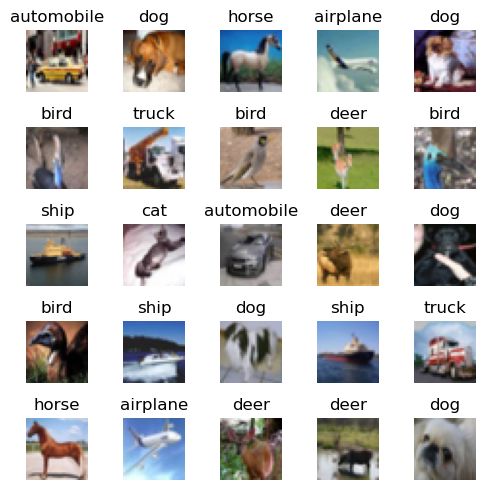

In [3]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

# 二、构建神经网络

In [32]:
import tensorflow as tf

def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

def swish(x, beta=1):
    return x * sigmoid(beta * x)

# 模型创建
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation=swish, kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))


# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

class get_lr(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lr_list = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lr_list.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs["loss"])

learning_rate_callback = get_lr()

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
history = model.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback])

Epoch 1/10
1563/1563 [==============================] - 23s 11ms/step - loss: 1.9348 - accuracy: 0.2798 - val_loss: 1.7911 - val_accuracy: 0.3466
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.7430 - accuracy: 0.3631 - val_loss: 1.6962 - val_accuracy: 0.3882
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.6491 - accuracy: 0.4009 - val_loss: 1.5947 - val_accuracy: 0.4237
Epoch 4/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5759 - accuracy: 0.4306 - val_loss: 1.5846 - val_accuracy: 0.4266
Epoch 5/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5244 - accuracy: 0.4495 - val_loss: 1.5287 - val_accuracy: 0.4486
Epoch 6/10
1563/1563 [==============================] - 16s 10ms/step - loss: 1.4827 - accuracy: 0.4633 - val_loss: 1.5053 - val_accuracy: 0.4614
Epoch 7/10
1563/1563 [==============================] - 16s 11ms/step - loss: 1.4492 - accuracy: 0.4789 - val_loss: 1.5204 -

In [33]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.4502 - accuracy: 0.4875


[1.4502028226852417, 0.48750001192092896]

## 添加批量归一化

In [34]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model1.add(tf.keras.layers.Dense(100, activation=swish, kernel_initializer="he_normal"))
    model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=3e-4)

model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

class get_lr(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lr_list = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lr_list.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs["loss"])

learning_rate_callback1 = get_lr()

history = model1.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback1])

Epoch 1/10
1563/1563 [==============================] - 35s 15ms/step - loss: 2.3695 - accuracy: 0.1483 - val_loss: 2.1864 - val_accuracy: 0.2033
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 2.0265 - accuracy: 0.2511 - val_loss: 1.9142 - val_accuracy: 0.3013
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.8897 - accuracy: 0.3115 - val_loss: 1.8298 - val_accuracy: 0.3353
Epoch 4/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7996 - accuracy: 0.3508 - val_loss: 1.7862 - val_accuracy: 0.3552
Epoch 5/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.7347 - accuracy: 0.3785 - val_loss: 1.7058 - val_accuracy: 0.3941
Epoch 6/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6845 - accuracy: 0.4000 - val_loss: 1.6649 - val_accuracy: 0.3986
Epoch 7/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6399 - accuracy: 0.4165 - val_loss: 1.6823 -

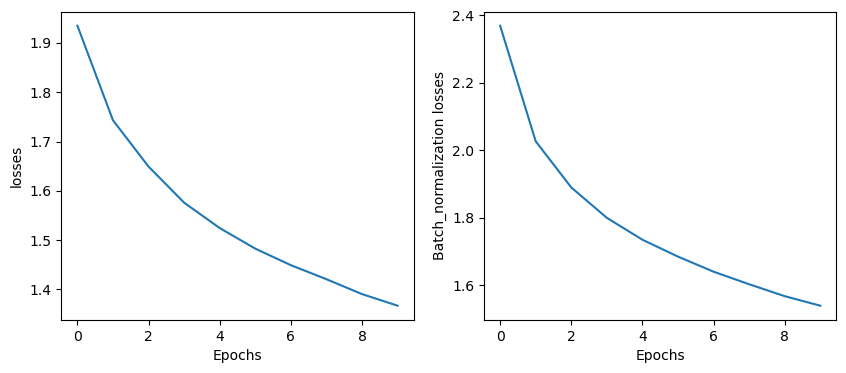

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(10), learning_rate_callback.losses)
plt.xlabel("Epochs")
plt.ylabel("losses")

plt.subplot(122)
plt.plot(range(10), learning_rate_callback1.losses)
plt.xlabel("Epochs")
plt.ylabel("Batch_normalization losses")
plt.show()

## SELU替换批量归一化

In [51]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model2.add(tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model2.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback])

Epoch 1/10
1563/1563 [==============================] - 30s 16ms/step - loss: 1.8652 - accuracy: 0.3184 - val_loss: 1.7074 - val_accuracy: 0.3829
Epoch 2/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.6904 - accuracy: 0.3883 - val_loss: 1.6653 - val_accuracy: 0.3976
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.6068 - accuracy: 0.4206 - val_loss: 1.5642 - val_accuracy: 0.4416
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5557 - accuracy: 0.4405 - val_loss: 1.5509 - val_accuracy: 0.4466
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5104 - accuracy: 0.4564 - val_loss: 1.5279 - val_accuracy: 0.4521
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.4816 - accuracy: 0.4682 - val_loss: 1.4944 - val_accuracy: 0.4701
Epoch 7/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.4527 - accuracy: 0.4792 - val_loss: 1.4985 -

In [52]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.4505 - accuracy: 0.4819


[1.4505146741867065, 0.48190000653266907]

### 使用Alpha dropout正则化模型

In [61]:
model3 = tf.keras.Sequential()

model3.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model3.add(tf.keras.layers.Dense(100,
                                     activation="selu",
                                     kernel_initializer="lecun_normal"))
    model3.add(tf.keras.layers.AlphaDropout(rate=0.02))
model3.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=9e-5)

model3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model3.fit(X_train_full, y_train_full,
                     epochs=10,
                     validation_data=(X_test, y_test),
                     callbacks=[early_stop])

Epoch 1/10
1563/1563 [==============================] - 46s 22ms/step - loss: 2.2037 - accuracy: 0.1831 - val_loss: 1.9110 - val_accuracy: 0.2762
Epoch 2/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.9599 - accuracy: 0.2689 - val_loss: 1.8616 - val_accuracy: 0.3250
Epoch 3/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.8683 - accuracy: 0.3165 - val_loss: 1.7461 - val_accuracy: 0.3666
Epoch 4/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.8115 - accuracy: 0.3427 - val_loss: 1.7038 - val_accuracy: 0.3923
Epoch 5/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.7675 - accuracy: 0.3615 - val_loss: 1.6477 - val_accuracy: 0.4079
Epoch 6/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.7251 - accuracy: 0.3796 - val_loss: 1.6496 - val_accuracy: 0.4109
Epoch 7/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.6933 - accuracy: 0.3893 - val_loss: 1.6174 -

In [46]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.5320 - accuracy: 0.4426


[1.5319969654083252, 0.4426000118255615]

## 一周期调度
其原理为：在训练的大约一半时间内线性增加学习率，然后线性降低回初始学习率，最后在训练的最后阶段将学习率线性/指数降低到0

In [49]:
import math
model4 = tf.keras.Sequential()

model4.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model4.add(tf.keras.layers.Dense(100,
                                     activation=swish,
                                     kernel_initializer="he_normal"))
model4.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-5)

model4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr, start_lr=None,
                 last_iterations=None, last_lr=None):
        super().__init__()
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

batch_size = 128
n_epochs = 10
m = X_train_full.shape[0]
one_cycle_sc = OneCycleScheduler(math.ceil(m / batch_size) * n_epochs, max_lr=0.001)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model4.fit(X_train_full, y_train_full, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),
          callbacks=[early_stop, one_cycle_sc])

Epoch 1/10
391/391 [==============================] - 23s 34ms/step - loss: 2.0100 - accuracy: 0.2510 - val_loss: 1.8422 - val_accuracy: 0.3212
Epoch 2/10
391/391 [==============================] - 14s 35ms/step - loss: 1.7705 - accuracy: 0.3567 - val_loss: 1.6913 - val_accuracy: 0.3873
Epoch 3/10
391/391 [==============================] - 15s 39ms/step - loss: 1.6693 - accuracy: 0.3975 - val_loss: 1.6380 - val_accuracy: 0.4153
Epoch 4/10
391/391 [==============================] - 14s 36ms/step - loss: 1.5995 - accuracy: 0.4247 - val_loss: 1.5942 - val_accuracy: 0.4311
Epoch 5/10
391/391 [==============================] - 14s 37ms/step - loss: 1.5644 - accuracy: 0.4394 - val_loss: 1.6186 - val_accuracy: 0.4272
Epoch 6/10
391/391 [==============================] - 14s 37ms/step - loss: 1.4865 - accuracy: 0.4688 - val_loss: 1.5131 - val_accuracy: 0.4672
Epoch 7/10
391/391 [==============================] - 15s 38ms/step - loss: 1.4127 - accuracy: 0.4938 - val_loss: 1.4710 - val_accuracy:

In [50]:
model4.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 1.3798 - accuracy: 0.5172


[1.3798432350158691, 0.5171999931335449]